Import packages:

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from classo import clr, classo_problem
from sklearn.model_selection import GridSearchCV
from scipy.stats import wilcoxon
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

We load the data. Datafiles are available at https://sid.erda.dk/cgi-sid/ls.py?share_id=EOdPUl8V7T 

In [24]:
biome = pd.read_csv('X_data.csv', delimiter=',', engine="c",
                index_col=0, dtype=defaultdict(np.float64, {0: str}))
metadata = pd.read_csv('meta_data.csv', delimiter=',', engine="c",
                index_col=0, dtype=str)

Preprocessing of data - we remove outliers and encode metadata features, as well as center-log ratio transforming for the log-contrast model and normalizing for the random forest.

In [25]:
bmi_known = ((~metadata["bmi"].isna()) &
       (metadata["bmi"] != "Unspecified") &
       (metadata["bmi"] != "unknown"))

bmi_reasonable = ((metadata.loc[bmi_known, "bmi"].astype(np.float64) >= 12) &
        (metadata.loc[bmi_known, "bmi"].astype(np.float64) <= 40))

featurelist = ["age_corrected", "sex", "exercise_frequency" ]

features_known = ((~metadata[featurelist].isna()) &
                   (metadata[featurelist] != "Unspecified") &
                   (metadata[featurelist] != "unknown") &
                    (metadata[featurelist] != "other")).all(1)

ind = bmi_reasonable & features_known

X_feature_extraction = metadata.loc[ind, ("age_corrected", "sex", 
                                          "exercise_frequency")]

X_features_onehot = pd.concat([X_feature_extraction["age_corrected"],
                      X_feature_extraction["sex"] == "male",
                      pd.get_dummies(X_feature_extraction["exercise_frequency"], drop_first=True)], axis=1).astype(np.float64)

X_features = pd.concat([X_feature_extraction["age_corrected"],
                      X_feature_extraction["sex"] == "male",
                      X_feature_extraction["exercise_frequency"].map({'Regularly (3-5 times/week)':3, 
                                                                      'Occasionally (1-2 times/week)':2, 
                                                                      'Daily':4,
                                                                      'Rarely (a few times/month)':1, 
                                                                      'Never':0})], axis=1).astype(np.float64)


X = biome.loc[ind, np.mean(biome != 0, axis=0) > 0.3].astype(np.float64)
Z = X / ((np.sum(X, axis=1)).values[:, np.newaxis])
X_clr = clr(X, 1/2)
Z_model = pd.concat([Z, X_features], axis=1)
X_clr_model = np.c_[X_clr, X_features_onehot]
X_features.columns = ["Age", "Sex", "Exercise frequency"]

y = metadata.loc[ind, "bmi"].astype(np.float64)

print(Z_model.shape)

(5976, 453)


In [26]:
print("in total there are", metadata.shape[0], "observations")
print("Of these,", np.sum(bmi_known), "have known bmi and", np.sum(bmi_reasonable), "are reasonable.")
print("When we exclude observations with unknown features we are left with", np.sum(features_known & bmi_reasonable) ,"observations.")

in total there are 7203 observations
Of these, 6993 have known bmi and 6560 are reasonable.
When we exclude observations with unknown features we are left with 5976 observations.


We implement a c-lasso estimator class for use with sklearn methods (see section 3.1 in the report)

In [27]:
class Classo_Reg(BaseEstimator):
    def __init__(self, alpha=0.01):
        self.alpha = alpha
    
    def fit(self, X, y, C):
        check_X_y(X, y)
        problem = classo_problem(X, y, C)
        # Formulation R1 (Constrained Lasso) with Intercept
        problem.formulation.huber = False   
        problem.formulation.concomitant = False
        problem.formulation.classification = False
        problem.formulation.intercept = True
        problem.model_selection.LAMfixed = True
        problem.model_selection.LAMfixedparameters.lam = self.alpha
        problem.model_selection.LAMfixedparameters.numerical_method = 'Path-Alg'
        problem.model_selection.StabSel = False 
        problem.solve()
        self.beta_ = problem.solution.LAMfixed.beta
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)        
        return (self.beta_[0] + X @ self.beta_[1:])
    
    def score(self, X, y):
        return mean_squared_error(y, self.predict(X))

Set up cross-validation folds with random state for reproduceability.

In [28]:
outer_cv = KFold(n_splits=10, shuffle = True, random_state=10)
inner_cv = KFold(n_splits=5,  shuffle = True, random_state=42)

alpha_grid = {
    'alpha': np.logspace(-3, -1, num=100)
}

classo_model = GridSearchCV(Classo_Reg(), alpha_grid, cv = inner_cv, scoring='neg_mean_squared_error')
lasso_model = LassoCV(n_alphas = 1000, cv = inner_cv)

We find the $r^2$ and MSE for log-contrast models with 10-fold cv and plot them

In [43]:
dummy = DummyRegressor(strategy='mean')

dummy_cv = cross_validate(dummy, Z, y, cv = outer_cv, scoring=('r2', 'neg_mean_squared_error'))
print("Reference r^2:           ", np.mean(dummy_cv['test_r2']))
print("Reference mse:          ", np.mean(-dummy_cv['test_neg_mean_squared_error']))

print("metadata only:")
lasso_metadata_cv = cross_validate(lasso_model, X_features_onehot, y, cv=outer_cv, scoring=('r2', 'neg_mean_squared_error'), n_jobs=-1)
print("lasso r^2:        ", np.mean(lasso_metadata_cv['test_r2']))
print("lasso mse:        ", -np.mean(lasso_metadata_cv['test_neg_mean_squared_error']))

C_biome = np.ones((1,X_clr.shape[1]))
C_both  = np.c_[np.ones((1, X_clr.shape[1])), np.zeros((1, X_features_onehot.shape[1]))]

print("biome only:")
classo_biome_cv = cross_validate(classo_model, X_clr, y, fit_params = {'C': C_biome},  cv=outer_cv, scoring=('r2', 'neg_mean_squared_error'), n_jobs=-1)
print("classo r^2:       ", np.mean(classo_biome_cv['test_r2']))
print("classo mse:       ", -np.mean(classo_biome_cv['test_neg_mean_squared_error']))

print("both:")
classo_both_cv = cross_validate(classo_model, X_clr_model, y, fit_params = {'C': C_both},  cv=outer_cv, scoring=('r2', 'neg_mean_squared_error'), n_jobs=-1)
print("classo r^2:       ", np.mean(classo_both_cv['test_r2']))
print("classo mse:       ", -np.mean(classo_both_cv['test_neg_mean_squared_error']))

Reference r^2:            -0.001721892394694957
Reference mse:           19.426742161399797
metadata only:
lasso r^2:         0.14111580838206775
lasso mse:         16.648490445269168
biome only:
classo r^2:        0.13046097708558677
classo mse:        16.87988991667036
both:
classo r^2:        0.2101112275108264
classo mse:        15.32335175837748


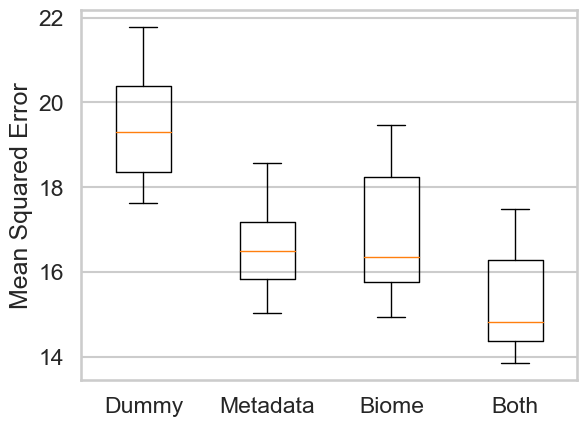

In [32]:
sns.set_style('whitegrid')
sns.set_context('talk')
fig, ax = plt.subplots()
ax.boxplot(np.c_[-dummy_cv['test_neg_mean_squared_error'],
                  -lasso_metadata_cv['test_neg_mean_squared_error'],
                  -classo_biome_cv['test_neg_mean_squared_error'], 
                  -classo_both_cv['test_neg_mean_squared_error']])
plt.xticks([1,2,3,4],['Dummy', 'Metadata', 'Biome', 'Both'])
plt.ylabel('Mean Squared Error')
ax.xaxis.grid(False)
plt.savefig('logcontrast_mses.png', bbox_inches='tight')
plt.show()

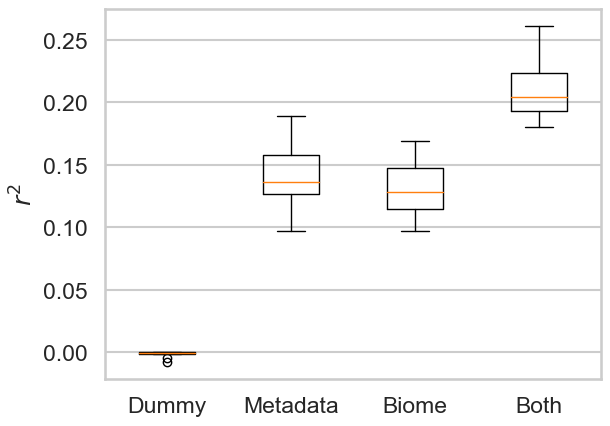

In [33]:
fig, ax = plt.subplots()
ax.boxplot(np.c_[dummy_cv['test_r2'],
                  lasso_metadata_cv['test_r2'],
                  classo_biome_cv['test_r2'], 
                  classo_both_cv['test_r2']])
plt.xticks([1,2,3,4],['Dummy', 'Metadata', 'Biome', 'Both'])
plt.ylabel(r'$r^2$')
ax.xaxis.grid(False)
plt.savefig('logcontrast_r2.png', bbox_inches='tight')
plt.show()

We similarly find the $r^2$ and MSE for the random forest models and plot them:

In [34]:
param_grid = {
    'max_samples':  [0.7, 0.85, 1.],
    'max_features': [0.7, 0.85, 1.],
    'min_samples_leaf': [5, 10, 15]
}

rf_cv_model        =      GridSearchCV(RandomForestRegressor(), param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs = -1)
dummy_cv = cross_validate(dummy, Z, y, cv = outer_cv, scoring=('r2', 'neg_mean_squared_error'))
print("Reference r^2:           ", np.mean(dummy_cv['test_r2']))
print("Reference mse:          ", np.mean(-dummy_cv['test_neg_mean_squared_error']))

print("only features")
rf_meta_cv = cross_validate(rf_cv_model, X_features, y, cv = outer_cv, scoring=('r2', 'neg_mean_squared_error'))
print("Random forest r^2:       ", np.mean(rf_meta_cv['test_r2']))
print("Random forest mse:       ", np.mean(-rf_meta_cv['test_neg_mean_squared_error']))
    
print("only biome")
rf_biome_cv = cross_validate(rf_cv_model, Z, y, cv = outer_cv, scoring=('r2', 'neg_mean_squared_error'))
print("Random forest r^2:       ", np.mean(rf_biome_cv['test_r2']))
print("Random forest mse:       ", np.mean(-rf_biome_cv['test_neg_mean_squared_error']))

print("both")   
rf_both_cv = cross_validate(rf_cv_model, Z_model, y, cv = outer_cv, scoring=('r2', 'neg_mean_squared_error'))
print("Random forest r^2:       ", np.mean(rf_both_cv['test_r2']))
print("Random forest mse:       ", np.mean(-rf_both_cv['test_neg_mean_squared_error']))

Reference r^2:            -0.001721892394694957
Reference mse:           19.426742161399797
only features
Random forest r^2:        0.20802442796068
Random forest mse:        15.359162880449855
only biome
Random forest r^2:        0.11039920185404936
Random forest mse:        17.272143448235035
both
Random forest r^2:        0.25184460187489816
Random forest mse:        14.51645244623702


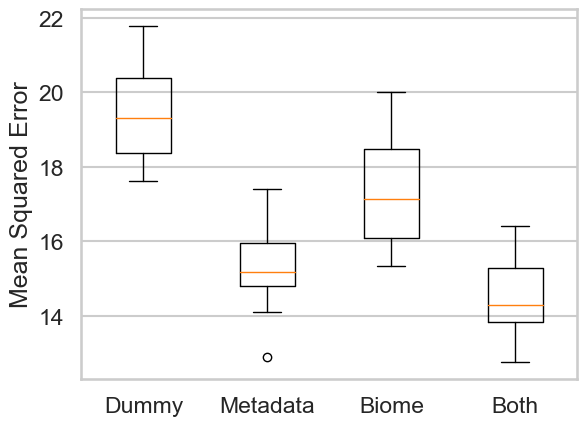

In [39]:
fig, ax = plt.subplots()
ax.xaxis.grid(False)
ax.boxplot(np.c_[-dummy_cv['test_neg_mean_squared_error'],
                  -rf_meta_cv['test_neg_mean_squared_error'],
                  -rf_biome_cv['test_neg_mean_squared_error'], 
                  -rf_both_cv['test_neg_mean_squared_error']])
plt.xticks([1,2,3,4],['Dummy', 'Metadata', 'Biome', 'Both'])
plt.ylabel('Mean Squared Error')
plt.savefig('rf_mses.png', bbox_inches='tight')
plt.show()

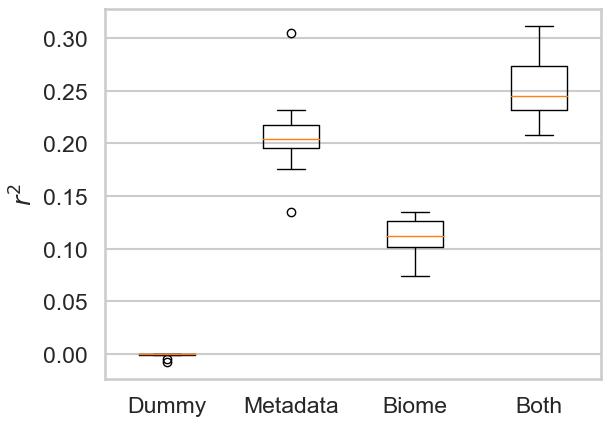

In [40]:
fig, ax = plt.subplots()
ax.xaxis.grid(False)
ax.boxplot(np.c_[dummy_cv['test_r2'],
                  rf_meta_cv['test_r2'],
                  rf_biome_cv['test_r2'], 
                  rf_both_cv['test_r2']])
plt.xticks([1,2,3,4],['Dummy', 'Metadata', 'Biome', 'Both'])
plt.ylabel(r'$r^2$')
plt.savefig('rf_r2.png', bbox_inches='tight')
plt.show()

We compare the models using a Wilcoxon signed-rank test. 

In [48]:
print("Wilcoxon signed ranked tests of equivalent predictive power:")
print("Logcontrast   vs random forests both microbiome and metadata     p-value: ", wilcoxon(-classo_both_cv['test_neg_mean_squared_error'], -rf_both_cv['test_neg_mean_squared_error']).pvalue)
print("Logcontrast   vs random forests microbiome only                  p-value: ", wilcoxon(-classo_biome_cv['test_neg_mean_squared_error'], -rf_biome_cv['test_neg_mean_squared_error']).pvalue)
print("Logcontrast   vs random forests metadata only                    p-value: ", wilcoxon(-lasso_metadata_cv['test_neg_mean_squared_error'], -rf_meta_cv['test_neg_mean_squared_error']).pvalue)
print("Random forests microbiome only vs both metadata and microbiome,  p-value: ", wilcoxon(-rf_biome_cv['test_neg_mean_squared_error'], -rf_both_cv['test_neg_mean_squared_error']).pvalue)
print("Random forests metadata   only vs both metadata and microbiome,  p-value: ", wilcoxon(-rf_meta_cv['test_neg_mean_squared_error'], -rf_both_cv['test_neg_mean_squared_error']).pvalue)
print("Random forests microbiome only vs dummy model,                   p-value: ", wilcoxon(-dummy_cv['test_neg_mean_squared_error'], -rf_biome_cv['test_neg_mean_squared_error']).pvalue)
print("Logcontrast both microbiome and metadata  vs metadata only       p-value: ", wilcoxon(-classo_both_cv['test_neg_mean_squared_error'], -lasso_metadata_cv['test_neg_mean_squared_error']).pvalue)
print("Logcontrast microbiome only vs dummy model,                      p-value: ", wilcoxon(-classo_biome_cv['test_neg_mean_squared_error'], -dummy_cv['test_neg_mean_squared_error']).pvalue)
print("Logcontrast microbiomeonly vs metadata features only             p-value: ", wilcoxon(-classo_biome_cv['test_neg_mean_squared_error'], -lasso_metadata_cv['test_neg_mean_squared_error']).pvalue)

Wilcoxon signed ranked tests of equivalent predictive power:
Logcontrast   vs random forests both microbiome and metadata     p-value:  0.001953125
Logcontrast   vs random forests microbiome only                  p-value:  0.009765625
Logcontrast   vs random forests metadata only                    p-value:  0.001953125
Random forests microbiome only vs both metadata and microbiome,  p-value:  0.001953125
Random forests metadata   only vs both metadata and microbiome,  p-value:  0.001953125
Random forests microbiome only vs dummy model,                   p-value:  0.001953125
Logcontrast both microbiome and metadata  vs metadata only       p-value:  0.001953125
Logcontrast microbiome only vs dummy model,                      p-value:  0.001953125
Logcontrast microbiomeonly vs metadata features only             p-value:  0.625
